# Statically tunable switching between energy focusing and protection


## Imports

In [1]:
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"  # Use 8 CPU cores for JAX pmap 

from difflexmm.utils import SolutionData, save_data, load_data, ControlParams, GeometricalParams, MechanicalParams, ContactParams
from difflexmm.geometry import QuadGeometry, compute_inertia, compute_xy_limits
from difflexmm.kinematics import block_to_node_kinematics
from difflexmm.plotting import generate_animation, plot_geometry
from problems.quads_kinetic_energy_static_tuning import ForwardInput, ForwardProblem, OptimizationProblem
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path
from typing import Any, Optional, List

import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)  # enable float64 type
# config.update("jax_log_compiles", 1)

plt.style.use(["science", "grid"])
%matplotlib widget


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Plotting functions


In [2]:
from difflexmm.energy import contact_energy, void_angles


def plot_objective_iterations(optimization: OptimizationProblem, optimization_filename: Optional[str] = None):

    fig, axes = plt.subplots(nrows=5, figsize=(
        10, 10), sharex=True, constrained_layout=True)
    axes[0].set(ylabel="Objective")
    axes[0].plot(optimization.objective_values, lw=3, color="#2980b9")
    axes[1].set(ylabel="Objective 1")
    axes[1].plot(jnp.array(optimization.objective_values_individual)[
                 :, 0], lw=3, color="#2980b9")
    axes[2].set(ylabel="Objective 2")
    axes[2].plot(jnp.array(optimization.objective_values_individual)[
                 :, 1], lw=3, color="#2980b9")
    axes[3].set(ylabel="Angle constraints violation")
    axes[3].plot(optimization.constraints_violation["angles"],
                 lw=3, color="#c0392b")
    axes[3].axhline(y=0, color="black")
    axes[4].set(ylabel="Edge length constraints violation")
    axes[4].plot(optimization.constraints_violation["edge_lengths"],
                 lw=3, color="#c0392b")
    axes[4].axhline(y=0, color="black")
    axes[-1].set(xlabel="Iteration")

    if optimization_filename is not None:
        path = Path(
            f"../out/{optimization.name}/{optimization_filename}/objective_iterations.png")
        # Make sure parents directories exist
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(str(path), dpi=300)


def plot_field_section(optimization: OptimizationProblem, optimization_filename: Optional[str] = None, n_timepoints: int = 200):

    if not optimization.forward_problem.is_setup:
        optimization.forward_problem.setup()

    problem = optimization.forward_problem

    forward_input_array = jnp.array([
        optimization.forward_input.amplitude,
        optimization.forward_input.loading_rate,
        optimization.forward_input.compressive_strain,
        optimization.forward_input.compressive_strain_rate,
    ]).T

    solution_datas = [
        problem.solve(
            optimization.design_values[-1], *forward_input, full_simulation_time=False, n_timepoints=n_timepoints)
        for forward_input in forward_input_array
    ] if optimization.forward_problem.solution_data is None else optimization.forward_problem.solution_data

    # Horizontal section
    section_blocks = jnp.array([
        j * problem.n1_blocks + i
        for i in range(problem.n1_blocks)
        for j in (problem.n2_blocks//2 + optimization.target_shifts[0][1],)
    ])

    fig, axes = plt.subplots(figsize=(10, 4), constrained_layout=True)
    labels = ["Focusing", "Protection"]
    colors = ["#c0392b", "#16a085"]
    axes.set_xlabel(r"$x$-direction (\# units)", fontsize=14)
    axes.set_ylabel(r"Velocity [mm/s]", fontsize=14)
    for solution_data, label, color in zip(solution_datas, labels, colors):
        axes.plot(
            (jnp.sum(
                solution_data.fields[:, 1, section_blocks, :2]**2, axis=2) ** 0.5).max(axis=0),
            lw=3, ls="-", color=color, label=f"Peak velocity - {label}"
        )
    axes.axvspan(
        (problem.n1_blocks - optimization.target_sizes[0][0]-1)/2 +
        optimization.target_shifts[0][0],
        (problem.n1_blocks + optimization.target_sizes[0][0]-1)/2 +
        optimization.target_shifts[0][0],
        color="#bdc3c7", alpha=0.3, label="Focusing/protected region"
    )
    axes.axhline(y=0, color="black")
    # axes.set_yscale('log')
    axes.legend(loc="upper left", framealpha=0.9)

    if optimization_filename is not None:
        path = Path(
            f"../out/{optimization.name}/{optimization_filename}/velocity_profile.png")
        # Make sure parents directories exist
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(str(path), dpi=300)


def plot_pareto_front(pareto_objectives_data: List, figsize=(4, 4), fontsize=14, ticksize=12, xlim=None, ylim=None, grid=True, colors=("#bdc3c7", "#bdc3c7")):
    fig, axes = plt.subplots(figsize=figsize, constrained_layout=True)
    # Create a radial color gradient
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        "pareto",
        colors,
    )
    max_objective_value = max(
        [jnp.linalg.norm(objective_values_ray, axis=1).max()
         for objective_values_ray in pareto_objectives_data]
    )
    # Plot pareto front
    for objective_values_ray in pareto_objectives_data:
        axes.scatter(
            objective_values_ray[:, 0], objective_values_ray[:, 1],
            s=3,
            color=cmap(jnp.linalg.norm(
                objective_values_ray, axis=1)/max_objective_value),
        )
    axes.set_xlabel(r"Task 1: Focusing [mJ]", fontsize=fontsize)
    axes.set_ylabel(r"Task 2: Protection [mJ]", fontsize=fontsize)
    # axes.axis("equal")
    axes.tick_params(labelsize=ticksize)

    if xlim is not None:
        axes.set_xlim(xlim)
    if ylim is not None:
        axes.set_ylim(ylim)
    if not grid:
        axes.grid(False)

    return fig, axes


def generate_response_animations(
        optimization: OptimizationProblem,
        optimization_filename: str,
        filename_prefix: str,
        full_simulation_time: bool = False,
        n_timepoints: int = 200,
        recompute: bool = False,
        **plot_kwargs):

    if not optimization.forward_problem.is_setup:
        optimization.forward_problem.setup()

    forward_input_array = jnp.array([
        optimization.forward_input.amplitude,
        optimization.forward_input.loading_rate,
        optimization.forward_input.compressive_strain,
        optimization.forward_input.compressive_strain_rate,
    ]).T

    if recompute or len(optimization.forward_problem.solution_data) == 0:
        for forward_input, target_size, target_shift in zip(forward_input_array, optimization.target_sizes, optimization.target_shifts):
            _, _, compressive_strain, _ = forward_input
            solution = optimization.forward_problem.solve(
                optimization.design_values[-1], *forward_input, full_simulation_time=full_simulation_time, n_timepoints=n_timepoints)
            xlim, ylim = optimization.forward_problem.geometry.get_xy_limits(
                *optimization.design_values[-1]) + 0.5*optimization.forward_problem.spacing * jnp.array([-1, 1])

            generate_animation(
                data=solution,
                field="v",
                out_filename=f"../out/{optimization.name}/{optimization_filename}/{filename_prefix}_target_size_{target_size}_target_shift_{target_shift}_compressive_strain_{compressive_strain}",
                deformed=True,
                xlim=xlim,
                ylim=ylim,
                **plot_kwargs
            )
    else:
        for forward_input, target_size, target_shift, solution in zip(forward_input_array, optimization.target_sizes, optimization.target_shifts, optimization.forward_problem.solution_data):
            _, _, compressive_strain, _ = forward_input
            xlim, ylim = optimization.forward_problem.geometry.get_xy_limits(
                *optimization.design_values[-1]) + 0.5*optimization.forward_problem.spacing * jnp.array([-1, 1])

            generate_animation(
                data=solution,
                field="v",
                out_filename=f"../out/{optimization.name}/{optimization_filename}/{filename_prefix}_target_size_{target_size}_target_shift_{target_shift}_compressive_strain_{compressive_strain}",
                deformed=True,
                xlim=xlim,
                ylim=ylim,
                **plot_kwargs
            )


def kinetic_energy_per_block(velocity, blocks_inertia):
    # velocity is (n_time_steps, n_blocks, 3)
    # blocks_inertia is (n_blocks, 3)
    return 0.5*jnp.sum(velocity**2 * blocks_inertia, axis=-1)


def average_kinetic_energy_per_block(solution_data, blocks_inertia):
    return jnp.sum(
        kinetic_energy_per_block(
            solution_data.fields[:, 1],
            blocks_inertia,
        )/solution_data.timepoints.shape[0],
        axis=0,
    )


def compute_contact_energies(block_displacement: jnp.ndarray, control_params: ControlParams, bond_connectivity):
    block_centroids = control_params.geometrical_params.block_centroids
    centroid_node_vectors = control_params.geometrical_params.centroid_node_vectors
    contact_params = control_params.mechanical_params.contact_params

    node_displacements = jnp.array(
        block_to_node_kinematics(
            block_displacement,
            centroid_node_vectors
        )
    )[:, :, :2]
    current_block_nodes = block_centroids[:, None] + \
        centroid_node_vectors + node_displacements
    energies = contact_energy(current_void_angles=void_angles(
        current_block_nodes, bond_connectivity), **contact_params._asdict())
    return jnp.sum(energies.reshape(2, -1), axis=0)


def plot_contact_and_kinetic_energy_vs_compression(optimization: OptimizationProblem, solution_data_list: List[SolutionData], column_labels=[], xlim=None, ylim=None, figsize=(6, 3), fontsize=14, grid=True, cmap_contact="inferno", cmap_kinetic="inferno", show_ticks=True):
    # Plot a contact and kinetic energy vs compression level (each column is a different compression level)
    problem = optimization.forward_problem
    solution_data = solution_data_list[0]
    row_labels = ["Contact", "Kinetic"]
    fig, axes = plt.subplots(nrows=2, ncols=len(solution_data_list), figsize=figsize,
                             sharex=True, sharey=True, constrained_layout=True)

    # Add column labels at the top
    for ax, label in zip(axes[0], column_labels):
        ax.set_title(label, fontsize=fontsize)
    # Add row labels on the left
    for ax, label in zip(axes[:, 0], row_labels):
        ax.set_ylabel(label, fontsize=fontsize)

    # Remove all ticks
    if not show_ticks:
        for ax in axes.flatten():
            ax.set_xticks([])
            ax.set_yticks([])
    else:
        # Add supxlabel at the bottom
        fig.supxlabel(r"$x$ [mm]", fontsize=fontsize,
                      x=0.55, y=0.1, ha="center", va="center")
        # Add supylabel on the right
        fig.supylabel(r"$y$ [mm]", fontsize=fontsize,
                      y=0.55, ha="left", va="center")
        for ax in axes[-1]:
            # ax.yaxis.set_label_position("right")
            # ax.set_ylabel(r"$y$ [mm]", fontsize=fontsize)
            ax.tick_params(labelsize=0.8*fontsize)
        for ax in axes[:, 0]:
            ax.tick_params(labelsize=0.8*fontsize)
        for ax in axes[:, -1]:
            # ax.set_xlabel(r"$x$ [mm]", fontsize=fontsize)
            ax.tick_params(labelsize=0.8*fontsize)

    block_points = (
        solution_data.block_centroids[:, None] + solution_data.centroid_node_vectors).reshape(-1, 2)
    reference_bond_vectors = block_points[solution_data.bond_connectivity[:, 1]] - \
        block_points[solution_data.bond_connectivity[:, 0]]
    bond_midpoints = jnp.mean(
        block_points[solution_data.bond_connectivity], axis=1)

    # Compute contact energy
    contact_energies = jnp.array([
        compute_contact_energies(
            block_displacement=solution_data.fields[0, 0],
            control_params=ControlParams(
                geometrical_params=GeometricalParams(
                    block_centroids=solution_data.block_centroids,
                    centroid_node_vectors=solution_data.centroid_node_vectors,
                ),
                mechanical_params=MechanicalParams(
                    bond_params=None,
                    density=0.,
                    contact_params=ContactParams(
                        k_contact=optimization.forward_problem.k_contact,
                        min_angle=optimization.forward_problem.min_angle,
                        cutoff_angle=optimization.forward_problem.cutoff_angle,
                    ),
                ),
            ),
            bond_connectivity=solution_data.bond_connectivity,
        )
        for solution_data in solution_data_list
    ])
    # Binary contact energies to show contact or no contact
    contact_energies = jnp.where(contact_energies > 0., 1., 0.)
    # Contact energy values limits
    contact_energy_min, contact_energy_max = jnp.min(
        contact_energies), jnp.max(contact_energies)

    # Compute kinetic energy
    kinetic_energies = jnp.array([
        average_kinetic_energy_per_block(
            solution_data,
            compute_inertia(
                vertices=solution_data.centroid_node_vectors, density=problem.density),
        ) for solution_data in solution_data_list
    ])
    # Kinetic energy values limits
    kinetic_energy_min, kinetic_energy_max = jnp.min(
        kinetic_energies), jnp.max(kinetic_energies)

    # Plot contact energies in the first row
    for ax, contact_energy_values in zip(axes[0], contact_energies):
        ax.tripcolor(
            bond_midpoints[:, 0], bond_midpoints[:, 1], contact_energy_values,
            cmap=cmap_contact,
            shading='gouraud',
            # norm=matplotlib.colors.PowerNorm(
            #     gamma=1./2., vmin=contact_energy_min, vmax=contact_energy_max,),  # gamma=1./2. for sqrt
            norm=matplotlib.colors.Normalize(
                vmin=contact_energy_min, vmax=contact_energy_max),
        )
        # ax.scatter(
        #     bond_midpoints[:, 0], bond_midpoints[:, 1], contact_energy_values,
        #     cmap=cmap_contact,
        #     # shading='gouraud',
        #     # norm=matplotlib.colors.PowerNorm(
        #     #     gamma=1./2., vmin=contact_energy_min, vmax=contact_energy_max,),  # gamma=1./2. for sqrt
        #     norm=matplotlib.colors.Normalize(vmin=contact_energy_min, vmax=contact_energy_max),
        # )
    # Plot kinetic energies in the second row
    for ax, kinetic_energy in zip(axes[-1], kinetic_energies):
        ax.tripcolor(
            solution_data.block_centroids[:,
                                          0], solution_data.block_centroids[:, 1], kinetic_energy,
            cmap=cmap_kinetic,
            shading='gouraud',
            norm=matplotlib.colors.PowerNorm(gamma=1./2., vmin=kinetic_energy_min,
                                             vmax=kinetic_energy_max,),  # gamma=1./2. for sqrt
        )

    if xlim is None:
        xlim = compute_xy_limits(block_points)[0]
    if ylim is None:
        ylim = compute_xy_limits(block_points)[1]
    for ax in axes.flatten():
        ax.set(xlim=xlim, ylim=ylim)
        # ax.axis("equal")

    # Remove all ticks and axes labels
    # for ax in axes.flatten():
    #     ax.set_xticks([])
    #     ax.set_yticks([])
    #     ax.set_xticklabels([])
    #     ax.set_yticklabels([])

    # contact_mappable = cm.ScalarMappable(norm=matplotlib.colors.PowerNorm(gamma=1./2., vmin=contact_energy_min, vmax=contact_energy_max,),
    #                                      cmap=cmap_contact)
    kinetic_mappable = cm.ScalarMappable(norm=matplotlib.colors.PowerNorm(gamma=1./2., vmin=kinetic_energy_min, vmax=kinetic_energy_max,),
                                         cmap=cmap_kinetic)
    # cb_contact = matplotlib.colors.ListedColormap(["black", "gray"], name="contact", N=2)
    # fig.colorbar(cb_contact, ax=axes[0, -1])
    # cb_contact = fig.colorbar(contact_mappable, ax=axes[0, -1], pad=0.25 if show_ticks else 0.11, aspect=25,
    #                           orientation="vertical", location="right")
    # cb_contact.ax.tick_params(labelsize=0.8*fontsize, pad=2.)
    # cb_contact.set_label(r"[mJ]", fontsize=fontsize)
    cb_kinetic = fig.colorbar(kinetic_mappable, ax=axes[-1, -1], pad=0.25 if show_ticks else 0.04, aspect=25*0.47,
                              orientation="vertical", location="right")
    cb_kinetic.ax.tick_params(labelsize=0.8*fontsize, pad=2.)
    cb_kinetic.set_label(r"[mJ]", fontsize=fontsize)

    # fig.align_ylabels([cb_contact.ax, cb_kinetic.ax])

    if not grid:
        for ax in axes.flatten():
            ax.grid(False)

    return fig, axes


def plot_design(optimization: OptimizationProblem, optimization_filename: Optional[str] = None, design_label: Optional[str] = None, iteration=-1, figsize=(10, 7), fontsize=None, grid=True, axis=True, field_values=None, cmap: Any = "inferno", vmin=None, vmax=None, color=None, cmap_label=None, scaling=1., deformed=False, block_displacements=None):

    if not optimization.forward_problem.is_setup:
        optimization.forward_problem.setup()

    xlim, ylim = optimization.forward_problem.geometry.get_xy_limits(
        *optimization.design_values[iteration]) + 0.25*optimization.forward_problem.spacing * jnp.array([[-1., 1.], [-0.5, 0.5]])

    fig, axes = plot_geometry(
        block_centroids=optimization.forward_problem.geometry.block_centroids(
            *optimization.design_values[iteration]),
        centroid_node_vectors=optimization.forward_problem.geometry.centroid_node_vectors(
            *optimization.design_values[iteration]),
        bond_connectivity=optimization.forward_problem.geometry.bond_connectivity(),
        deformed=deformed,
        block_displacements=block_displacements,
        figsize=figsize,
        color="#2980b9",
        xlim=xlim,
        ylim=ylim,
    )
    axes.set_xlabel(r"$x$ [mm]", fontsize=fontsize)
    axes.set_ylabel(r"$y$ [mm]", fontsize=fontsize)
    # axes.set_aspect("equal")
    axes.tick_params(labelsize=fontsize)
    if not grid:
        axes.grid(False)
    if not axis:
        axes.axis("off")

    if field_values is not None and color is None:
        axes.collections[0].set_array(field_values)
        axes.collections[0].set_cmap(cmap)
        axes.collections[0].set_norm(
            matplotlib.colors.PowerNorm(
                gamma=scaling,
                vmin=jnp.min(field_values) if vmin is None else vmin,
                vmax=jnp.max(field_values) if vmax is None else vmax,
            )
        )
        cb = fig.colorbar(axes.collections[0], ax=axes, pad=0.01, aspect=12)
        cb.ax.tick_params(
            labelsize=0.8*fontsize if fontsize is not None else None)
        # Set ticklabels to have 1 decimal place
        cb.set_ticks(cb.get_ticks())
        cb.set_ticklabels([f"{tick:.1f}" for tick in cb.get_ticks()])
        cb.set_label(cmap_label, fontsize=fontsize)

    iteration_label = iteration if iteration >= 0 else len(
        optimization.design_values) + iteration
    if optimization_filename is not None:
        _design_label = f"design_{iteration_label:03d}_{design_label}" if design_label is not None else f"design_{iteration_label:03d}"
        path = Path(
            f"../out/{optimization.name}/{optimization_filename}/{_design_label}.png")
        # Make sure parents directories exist
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(str(path), dpi=300)

    return fig, axes

## Optimal design and response


In [3]:
# NOTE: Units are mm, N, s

# Geometrical params
n1_blocks = 24
n2_blocks = 18
spacing = 15.  # 1.0  # 15 mm
hinge_length = 0.15*spacing  # Same as bond length
# horizontal_shifts = jnp.zeros((n1_blocks+1, n2_blocks, 2))  # Initial design
# vertical_shifts = jnp.zeros((n1_blocks, n2_blocks+1, 2))  # Initial design
initial_angle = 25*jnp.pi/180
horizontal_shifts, vertical_shifts = QuadGeometry(n1_blocks, n2_blocks, spacing=spacing, bond_length=hinge_length).get_design_from_rotated_square(
    angle=initial_angle,
)  # Initial design

# Mechanical params
k_stretch = 120.  # stretching stiffness 120. N/mm
k_shear = 1.19  # shearing stiffness 1.19 N/mm
k_rot = 1.50  # rotational stiffness 1.50 Nmm
density = 6.18e-9  # Mg/mm^2
# NOTE: Damping is assumed to be the same for all blocks as it is small enough that the inertia change during optimization is negligible.
# The reference is taken to be zero angle rotated square geometry.
# 0.36125, 0.02175026 = mass and inertia of a single square of zero angle and unitary spacing and density and 0.15 bond length.
damping = 0.0186 * jnp.array([
    2 * (0.36125 * density * spacing**2 * k_shear)**0.5,
    2 * (0.36125 * density * spacing**2 * k_shear)**0.5,
    2 * (0.02175026 * density * spacing**4 * k_rot)**0.5
]) * jnp.ones((n1_blocks*n2_blocks, 3))

# Forward input for the two problems to be optimized
amplitude = 0.5 * spacing
loading_rate = 30.  # Hz loading frequency for dynamic input
compressive_strain = (0.01, 0.08)  # mm/mm for the static lateral compression
# mm/mm/s for the static lateral compression. NOTE: make sure it is non-zero.
compressive_strain_rate = (0.25, 0.25)
# Forward problem
problem = ForwardProblem(
    n1_blocks=n1_blocks,
    n2_blocks=n2_blocks,
    spacing=spacing,
    bond_length=hinge_length,
    k_stretch=k_stretch,
    k_shear=k_shear,
    k_rot=k_rot,
    density=density,
    damping=damping,
    k_contact=k_rot,
    min_angle=-10*jnp.pi/180,
    cutoff_angle=-5*jnp.pi/180,
    n_excited_blocks=2,
    input_shift=0,
    simulation_time_dynamic=2*loading_rate**-1,  # s
    n_timepoints=200,
    name="quads_focusing_vs_protection_static_tuning_3dp_pla_shims",
    atol=1e-4,
)

forward_input = ForwardInput(
    amplitude=(amplitude, amplitude),  # mm
    loading_rate=(loading_rate, loading_rate),  # Hz
    compressive_strain=compressive_strain,  # mm/mm
    compressive_strain_rate=compressive_strain_rate,  # mm/mm/s
    horizontal_shifts=horizontal_shifts,  # Initial design
    vertical_shifts=vertical_shifts,  # Initial design
)

# Optimization problem
target_sizes = ((2, 2), (2, 2))  # For this problem the target is the same for both problems
target_shifts = ((2, 2), (2, 2))
weights = (0.75, -0.25)  # (Focusing, Protection) # NOTE: Negative weights mean protection.
optimization = OptimizationProblem(
    forward_problem=problem,
    forward_input=forward_input,
    target_sizes=target_sizes,
    target_shifts=target_shifts,
    weights=weights,
    name=problem.name,
)

problem_filename_prefix = f"quads{'_linearized_strains' if optimization.forward_problem.linearized_strains else ''}_{optimization.forward_problem.n1_blocks}x{optimization.forward_problem.n2_blocks}_excited_blocks_{optimization.forward_problem.n_excited_blocks}_amplitude_{optimization.forward_input.amplitude[0]:.2f}_loading_rate_{optimization.forward_input.loading_rate[0]:.2f}_input_shift_{optimization.forward_problem.input_shift}_initial_angle_{initial_angle*180/jnp.pi:.1f}"
optimization_filename = f"opt_with_angle_30_and_length_3_constraints_{problem_filename_prefix}_target_size_{optimization.target_sizes[0]}_target_shifts_{optimization.target_shifts}_compressive_strains_{optimization.forward_input.compressive_strain}_weights_{optimization.weights}"


### Import most recent optimization object


In [4]:
optimization = OptimizationProblem.from_data(
    load_data(
        f"../data/{optimization.name}/{optimization_filename}.pkl",
    )
)


### Run optimization


In [ ]:
optimization.run_optimization_nlopt(
    initial_guess=(horizontal_shifts, vertical_shifts),
    # initial_guess=optimization.design_values[-1],
    n_iterations=80,
    min_block_angle=30*jnp.pi/180,
    min_void_angle=0*jnp.pi/180,
    min_edge_length=3.,  # mm
    max_time=8*60*60,  # 8 hour
    # lower_bound=-0.22*optimization.forward_problem.spacing,
    # upper_bound=0.22*optimization.forward_problem.spacing,
)

save_data(
    f"../data/{optimization.name}/{optimization_filename}.pkl",
    optimization.to_data()  # Optimization problem
)


## Plots

In [71]:
optimization = OptimizationProblem.from_data(
    load_data(
        f"../data/{optimization.name}/{optimization_filename}.pkl",
    )
)


### Plot objective function

In [ ]:
plot_objective_iterations(optimization=optimization, optimization_filename=optimization_filename)


### Plot velocity profile

In [ ]:
plot_field_section(optimization=optimization, optimization_filename=optimization_filename)


### Animation

In [ ]:
generate_response_animations(
    optimization=optimization,
    optimization_filename=optimization_filename,
    filename_prefix=problem_filename_prefix,
    figsize=(12, 8),
    full_simulation_time=False,  # Whether or not include the static compression in the animation.
    n_timepoints=200,
    recompute=False,
    dpi=150,
    fps=30,
    cmap="inferno",
)


## Pareto results


In [5]:
pareto_folder = f"opt_with_angle_30_and_length_3_constraints_quads{'_linearized_strains' if optimization.forward_problem.linearized_strains else ''}_{optimization.forward_problem.n1_blocks}x{optimization.forward_problem.n2_blocks}_excited_blocks_{optimization.forward_problem.n_excited_blocks}_amplitude_{optimization.forward_input.amplitude[0]:.2f}_loading_rate_{optimization.forward_input.loading_rate[0]:.2f}_input_shift_{optimization.forward_problem.input_shift}_target_sizes_{optimization.target_sizes}_target_shifts_{optimization.target_shifts}_compressive_strains_{optimization.forward_input.compressive_strain}"

### Sampled Pareto front

In [7]:
# Import optimization data files from pareto folder
pareto_objectives_data = []
for path in Path(f"../data/{optimization.name}/pareto/{pareto_folder}/").glob("*.pkl"):
    optimization = OptimizationProblem.from_data(load_data(path))
    pareto_objectives_data.append(
        jnp.array(optimization.objective_values_individual) /
        optimization.forward_problem.n_timepoints
    )

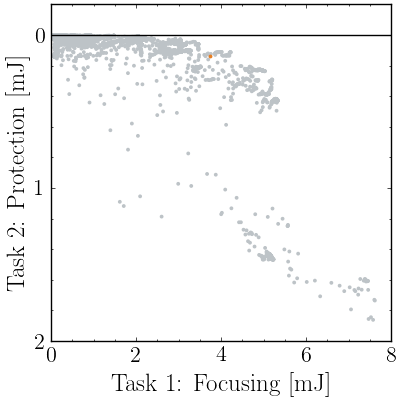

In [74]:
fig, axes = plot_pareto_front(
    pareto_objectives_data,
    figsize=(4, 4),
    xlim=(0, 8),
    ylim=(2, -0.2),
    fontsize=18,
    ticksize=16,
    grid=False,
    # colors=("#ecf0f1", "#e67e22"),
)
# Add x axis line at y=0
axes.axhline(y=0, color="black")
# Make spines thicker
for spine in axes.spines.values():
    spine.set_linewidth(1)
axes.locator_params(axis="both", integer=True)
# Add fabricated design
optimization = OptimizationProblem.from_data(
    load_data(
        f"../data/{optimization.name}/{optimization_filename}.pkl",
    )
)
axes.scatter(
    *jnp.array(optimization.objective_values_individual)[-1].T /
    optimization.forward_problem.n_timepoints,
    s=3,
    color="#e67e22",
    zorder=10,
)
path = Path(
    f"../out/{optimization.name}/pareto/{pareto_folder}/pareto_front.png")
path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(str(path), dpi=300)

## Fabricated design

In [4]:
# Retrieve design info from optimization data
optimization_filename = f"opt_with_angle_30_and_length_3_constraints_quads_24x18_excited_blocks_2_amplitude_7.50_loading_rate_30.00_input_shift_0_initial_angle_25.0_target_size_(2, 2)_target_shifts_((2, 2), (2, 2))_compressive_strains_(0.01, 0.08)_weights_(0.75, -0.25)"
optimization = OptimizationProblem.from_data(
    load_data(
        f"../data/quads_focusing_vs_protection_static_tuning_3dp_pla_shims/{optimization_filename}.pkl",
    )
)


### Plot design

(<Figure size 550x370 with 1 Axes>,
 <Axes: xlabel='$x$ [mm]', ylabel='$y$ [mm]'>)

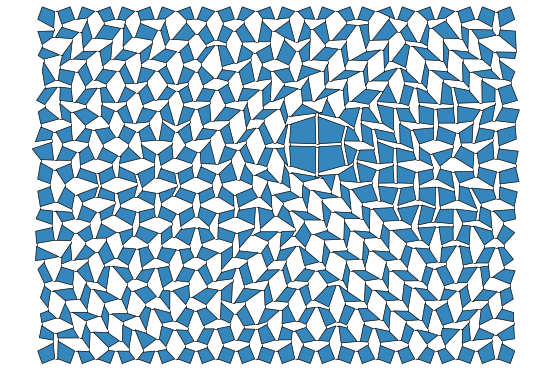

In [5]:
plot_design(
    optimization=optimization,
    optimization_filename=f"{optimization_filename}",
    figsize=(5.5, 3.7),
    axis=False
)


### Contact and kinetic energy maps vs strain

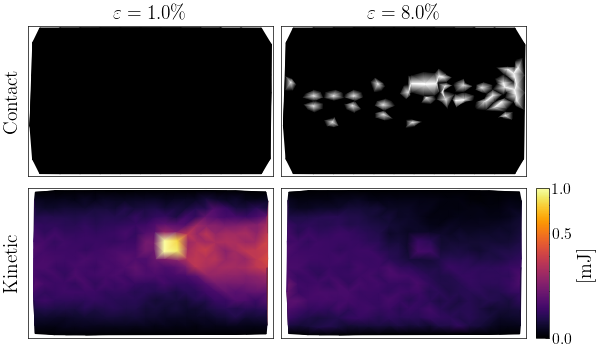

In [7]:
fig, axes = plot_contact_and_kinetic_energy_vs_compression(
    optimization,
    solution_data_list=optimization.forward_problem.solution_data,
    column_labels=[
        fr"$\varepsilon={compressive_strain*100:.1f}\%$" for compressive_strain in optimization.forward_input.compressive_strain],
    grid=False,
    figsize=(6, 3.5),
    cmap_kinetic="inferno",
    cmap_contact="binary_r",
    fontsize=14,
    show_ticks=False,
)
fig.savefig(
    f"../out/{optimization.name}/{optimization_filename}/contact_and_kinetic_energy_vs_compression.png",
    dpi=300
)

### Plot contact maps on design

In [14]:
# Compute contact energy
contact_energies = jnp.array([
    compute_contact_energies(
        block_displacement=solution_data.fields[0, 0],
        control_params=ControlParams(
            geometrical_params=GeometricalParams(
                block_centroids=solution_data.block_centroids,
                centroid_node_vectors=solution_data.centroid_node_vectors,
            ),
            mechanical_params=MechanicalParams(
                bond_params=None,
                density=0.,
                contact_params=ContactParams(
                    k_contact=optimization.forward_problem.k_contact,
                    min_angle=optimization.forward_problem.min_angle,
                    cutoff_angle=optimization.forward_problem.cutoff_angle,
                ),
            ),
        ),
        bond_connectivity=solution_data.bond_connectivity,
    )
    for solution_data in optimization.forward_problem.solution_data
])
# Binary contact energies to show contact or no contact
contact_energies = jnp.where(contact_energies > 0., 1., 0.)
# Binary array with blocks in contact or not
contact_state_blocks = jnp.zeros(
    (2, optimization.forward_problem.solution_data[0].block_centroids.shape[0]), dtype=contact_energies.dtype)
contact_state_blocks = contact_state_blocks.at[:,
                                               optimization.forward_problem.solution_data[0].bond_connectivity[:, 0]//4].add(contact_energies)
contact_state_blocks = contact_state_blocks.at[:,
                                               optimization.forward_problem.solution_data[0].bond_connectivity[:, 1]//4].add(contact_energies)
contact_state_blocks = jnp.where(contact_state_blocks > 0., 1., 0.)

#### Compressive strain: 1%

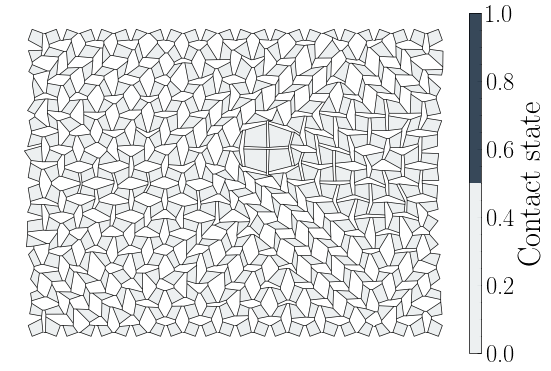

In [22]:
solution_data = optimization.forward_problem.solution_data[0]
design_label = f"contacts_compression_{optimization.forward_input.compressive_strain[0]:.2f}"
fig, axes = plot_design(
    optimization=optimization,
    optimization_filename=f"{optimization_filename}",
    design_label=design_label,
    figsize=(5.5, 3.7),
    field_values=contact_state_blocks[0],
    vmin=0,
    vmax=1,
    deformed=True,
    block_displacements=solution_data.fields[0, 0],
    scaling=1.,
    cmap=matplotlib.colors.LinearSegmentedColormap.from_list(
        "cmap",
        ("#ecf0f1", "#2c3e50"),
        N=2
    ),
    cmap_label="Contact state",
    fontsize=22,
    grid=False,
    axis=False,
)

#### Compressive strain: 8%

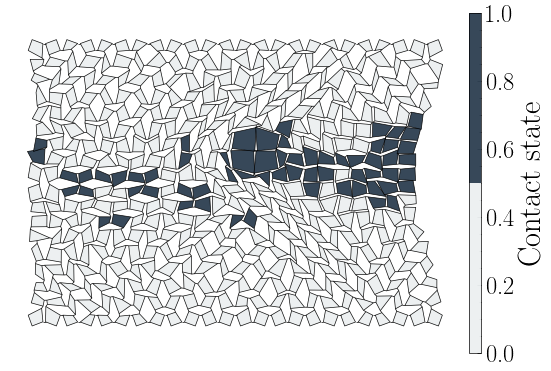

In [16]:
solution_data = optimization.forward_problem.solution_data[1]
design_label = f"contacts_compression_{optimization.forward_input.compressive_strain[1]:.2f}"
fig, axes = plot_design(
    optimization=optimization,
    optimization_filename=f"{optimization_filename}",
    design_label=design_label,
    figsize=(5.5, 3.7),
    field_values=contact_state_blocks[1],
    vmin=0,
    vmax=1,
    deformed=True,
    block_displacements=solution_data.fields[0, 0],
    scaling=1.,
    cmap=matplotlib.colors.LinearSegmentedColormap.from_list(
        "cmap",
        ("#ecf0f1", "#2c3e50"),
        N=2
    ),
    cmap_label="Contact state",
    fontsize=22,
    grid=False,
    axis=False,
)

### Plot average kinetic energy on design


#### Compressive strain: 1%

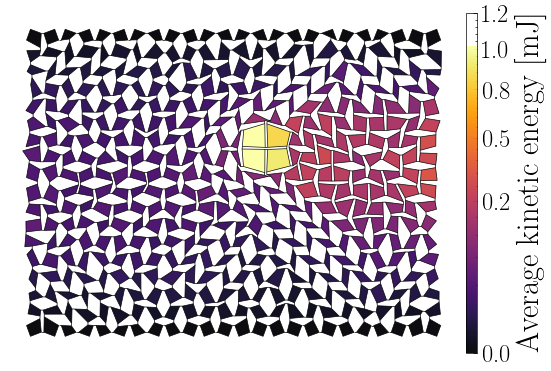

In [17]:
solution_data = optimization.forward_problem.solution_data[0]
design_label = f"average_kinetic_energy_compression_{optimization.forward_input.compressive_strain[0]:.2f}"
fig, axes = plot_design(
    optimization=optimization,
    optimization_filename=f"{optimization_filename}",
    design_label=design_label,
    figsize=(5.5, 3.7),
    field_values=average_kinetic_energy_per_block(
        solution_data,
        compute_inertia(
            vertices=solution_data.centroid_node_vectors,
            density=optimization.forward_problem.density,
        )
    ),
    deformed=True,
    block_displacements=solution_data.fields[0, 0],
    scaling=0.5,
    cmap="inferno",
    cmap_label="Average kinetic energy [mJ]",
    fontsize=22,
    grid=False,
    axis=False,
)

#### Compressive strain: 8%

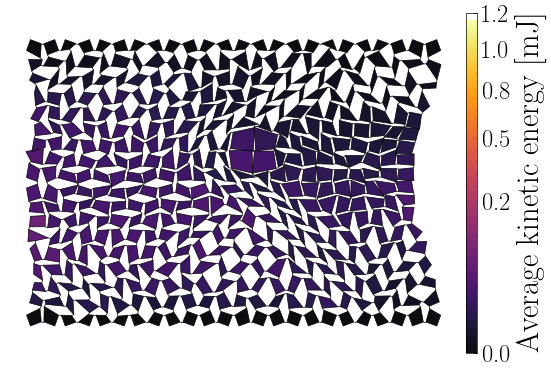

In [20]:
solution_data = optimization.forward_problem.solution_data[1]
design_label = f"average_kinetic_energy_compression_{optimization.forward_input.compressive_strain[1]:.2f}"
fig, axes = plot_design(
    optimization=optimization,
    optimization_filename=f"{optimization_filename}",
    design_label=design_label,
    figsize=(5.5, 3.7),
    field_values=average_kinetic_energy_per_block(
        solution_data,
        compute_inertia(
            vertices=solution_data.centroid_node_vectors,
            density=optimization.forward_problem.density,
        )
    ),
    vmin=0,
    vmax=1.2,
    deformed=True,
    block_displacements=solution_data.fields[0, 0],
    scaling=0.5,
    cmap="inferno",
    cmap_label="Average kinetic energy [mJ]",
    fontsize=22,
    grid=False,
    axis=False,
)